In [1]:
# ============================================
# OLIVE PROCESS-BASED MODEL (ENGLISH VERSION)
# Reference: Moriondo et al. (2019) / Villalobos et al. (2013)
# Configuration: Super-Intensive Arbequina (Chile)
# ============================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


columns = ["T2M_MIN", "T2M_MAX", "PRECTOTCORR", "ALLSKY_SFC_SW_DWN", "RH2M", "WS2M"]

Omega = np.load("../genai/scenarios.npy")
df = pd.DataFrame(Omega[0], columns=columns)


print(df.columns)
fixed_window = pd.read_csv('../genai/fixed_window.csv', index_col=0)
print(fixed_window.columns)
fixed_window.columns = columns
print(fixed_window.columns)
df = pd.concat([fixed_window, df])
print(df.columns)
try:
    
    #df['T2M'] = (df["T2M_MIN"] + df["T2M_MAX"])/2 
    print(df.columns)
    #df.rename(columns={"ALLSKY_SFC_SW_DWN":"RS", "CLRSKY_SFC_SW_DWN": "RSO",
    #            "PRECTOTCORR": "PRECIPITATION"}, inplace=True)
    # CLRSKY_SFC_SW_DWN?
    #df['RSO'] = df['RS']
    #print(df.columns)
    # Merge with real data and fix scenario generation according tactical planning  
    df_season = df#.loc['2022-11-01':'2023-04-29'].copy()
    if len(df_season) < 180:
        print(f"Warning: Season data is short ({len(df_season)} days). Using available data.")
    else:
        df_season = df_season.iloc[:180]
    print(f"Loaded {len(df_season)} days of weather data for simulation.")
except FileNotFoundError:
    print("="*50)
    print("ERROR: Data file not found. Please re-run Cell 4 to download the data.")
    print("="*50)

Index(['T2M_MIN', 'T2M_MAX', 'PRECTOTCORR', 'ALLSKY_SFC_SW_DWN', 'RH2M',
       'WS2M'],
      dtype='object')
Index(['0', '1', '2', '3', '4', '5'], dtype='object')
Index(['T2M_MIN', 'T2M_MAX', 'PRECTOTCORR', 'ALLSKY_SFC_SW_DWN', 'RH2M',
       'WS2M'],
      dtype='object')
Index(['T2M_MIN', 'T2M_MAX', 'PRECTOTCORR', 'ALLSKY_SFC_SW_DWN', 'RH2M',
       'WS2M'],
      dtype='object')
Index(['T2M_MIN', 'T2M_MAX', 'PRECTOTCORR', 'ALLSKY_SFC_SW_DWN', 'RH2M',
       'WS2M'],
      dtype='object')
Loaded 180 days of weather data for simulation.


In [2]:
df_season.reset_index(inplace=True)


In [3]:
print(df)

from datetime import date, timedelta

start_date = date(2024, 8, 30)
# Create a list of 180 days, starting from the day after start_date
date_list = [start_date + timedelta(days=x) for x in range(1, 181)]

df['DATE'] = date_list

df.DATE = pd.to_datetime(df.DATE)
df.set_index('DATE', inplace=True)

     T2M_MIN    T2M_MAX  PRECTOTCORR  ALLSKY_SFC_SW_DWN       RH2M      WS2M
0   6.830000  18.260000     0.000000           6.540000  82.480000  1.130000
1   6.200000  15.340000     0.000000           6.370000  84.810000  1.240000
2   4.590000  16.790000     0.000000          15.850000  74.550000  2.050000
3   0.970000  23.150000     0.000000          18.940000  63.160000  1.980000
4   4.630000  21.940000     0.000000          19.380000  66.540000  1.190000
..       ...        ...          ...                ...        ...       ...
55  8.750850  13.817754     2.698063           7.132063  77.296646  1.693531
56  5.466936  18.642084     0.740222          23.911379  72.229591  1.372966
57  4.688178  20.801809     0.128090          29.092003  70.570923  1.582005
58  6.155434  23.774721    -0.291742          26.166977  66.427025  1.409660
59  8.226084  26.256895    -0.175512          25.574631  67.752052  1.665095

[180 rows x 6 columns]


# 2026-01-23 Model 2.0

[INFO] Final modelling dataframe: 2024-08-31 -> 2025-02-26 | n=180
[INFO] Radiation units: MJ/m²/day detected (×1.0)
[INFO] Mean ALLSKY=24.71 | Mean SRAD_MJ=24.71 | Mean RAD_MJ(PAR)=11.86
--- STARTING SIMULATION: ---
Date window: 2024-08-31 to 2025-02-26
Strategy: Irrigation Threshold = 0.20 (FTSW)
Harvest DOY (Chile init): 120  (calibrate with farm records)
Phenology models: Chill=unichill | Forcing=logistic
[PHENO] 2024-09-17 dormancy released | chill_cum=367.1
[PHENO] 2024-10-12 anthesis reached
[HI] 2024-10-18 HIa fixed | HIws=0.350, HIhs=0.350, HIa=0.350

FINAL AUDIT (Chile) | LOC
Seasons evaluated (SEASON_YEAR): [2024]
Phenology models: Chill=unichill | Forcing=logistic
Harvest DOY: 120  | Irrigation threshold FTSW=0.20
--------------------------------------------------------------------------------
Average Yield (DM):      6610 kg/ha
Average Yield (Fresh*):  14542 kg/ha   (*fresh_factor=2.2)
Average Irrigation:      311 mm/season-year
Alternate Bearing Index: nan   [Eq. 41]
----

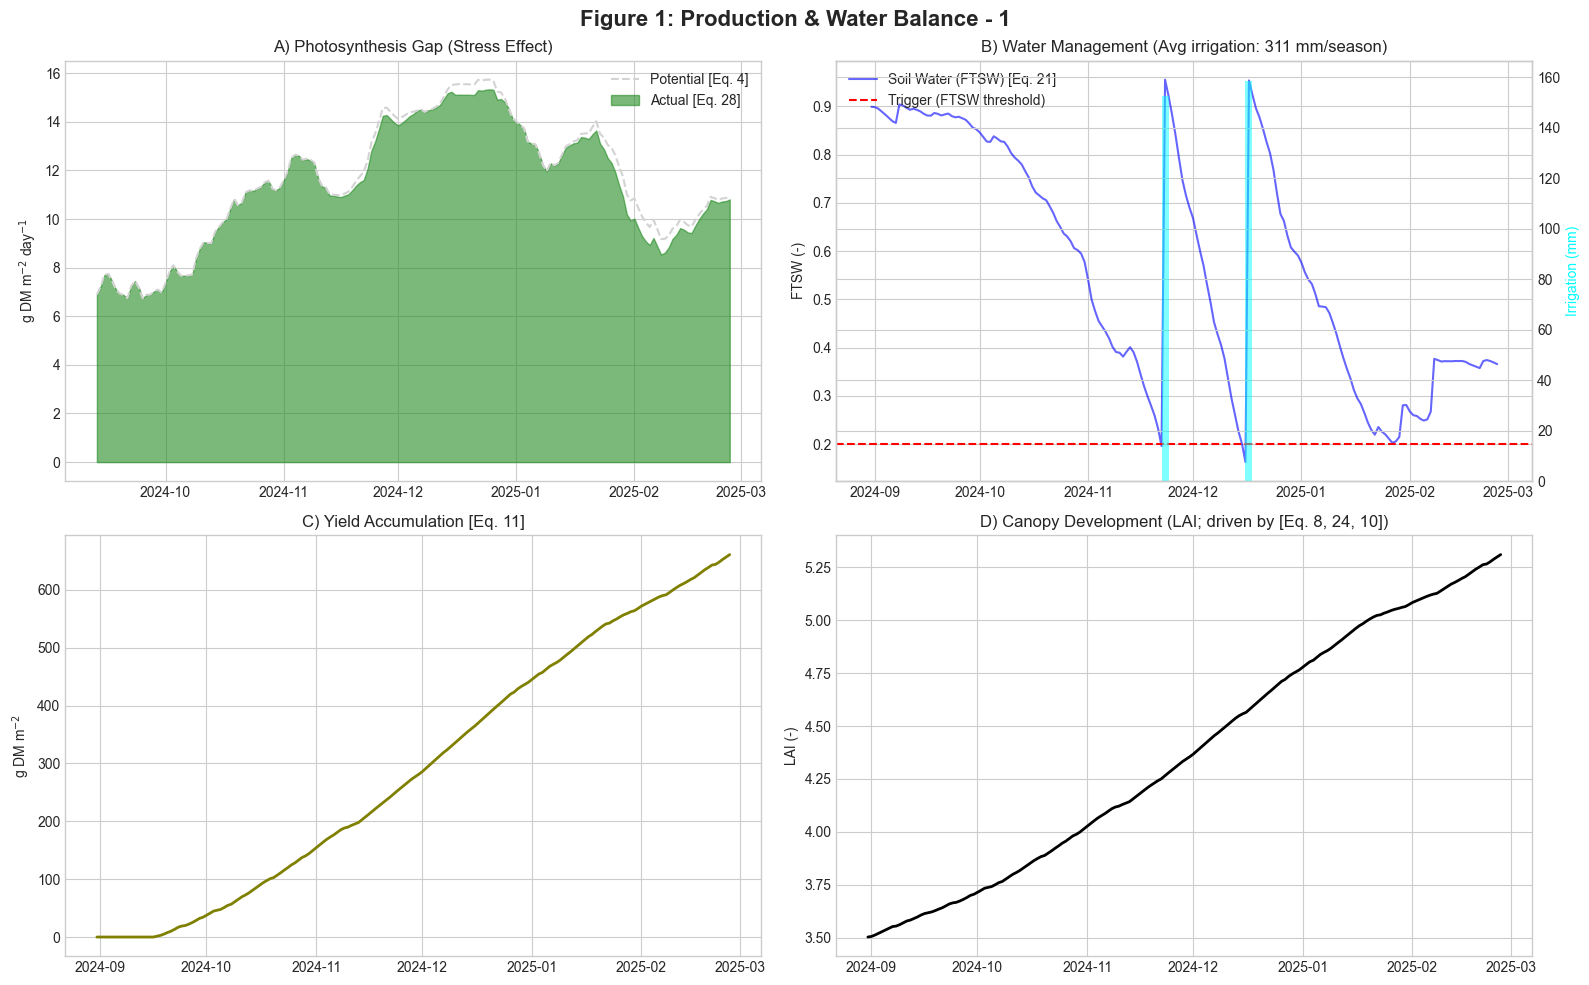

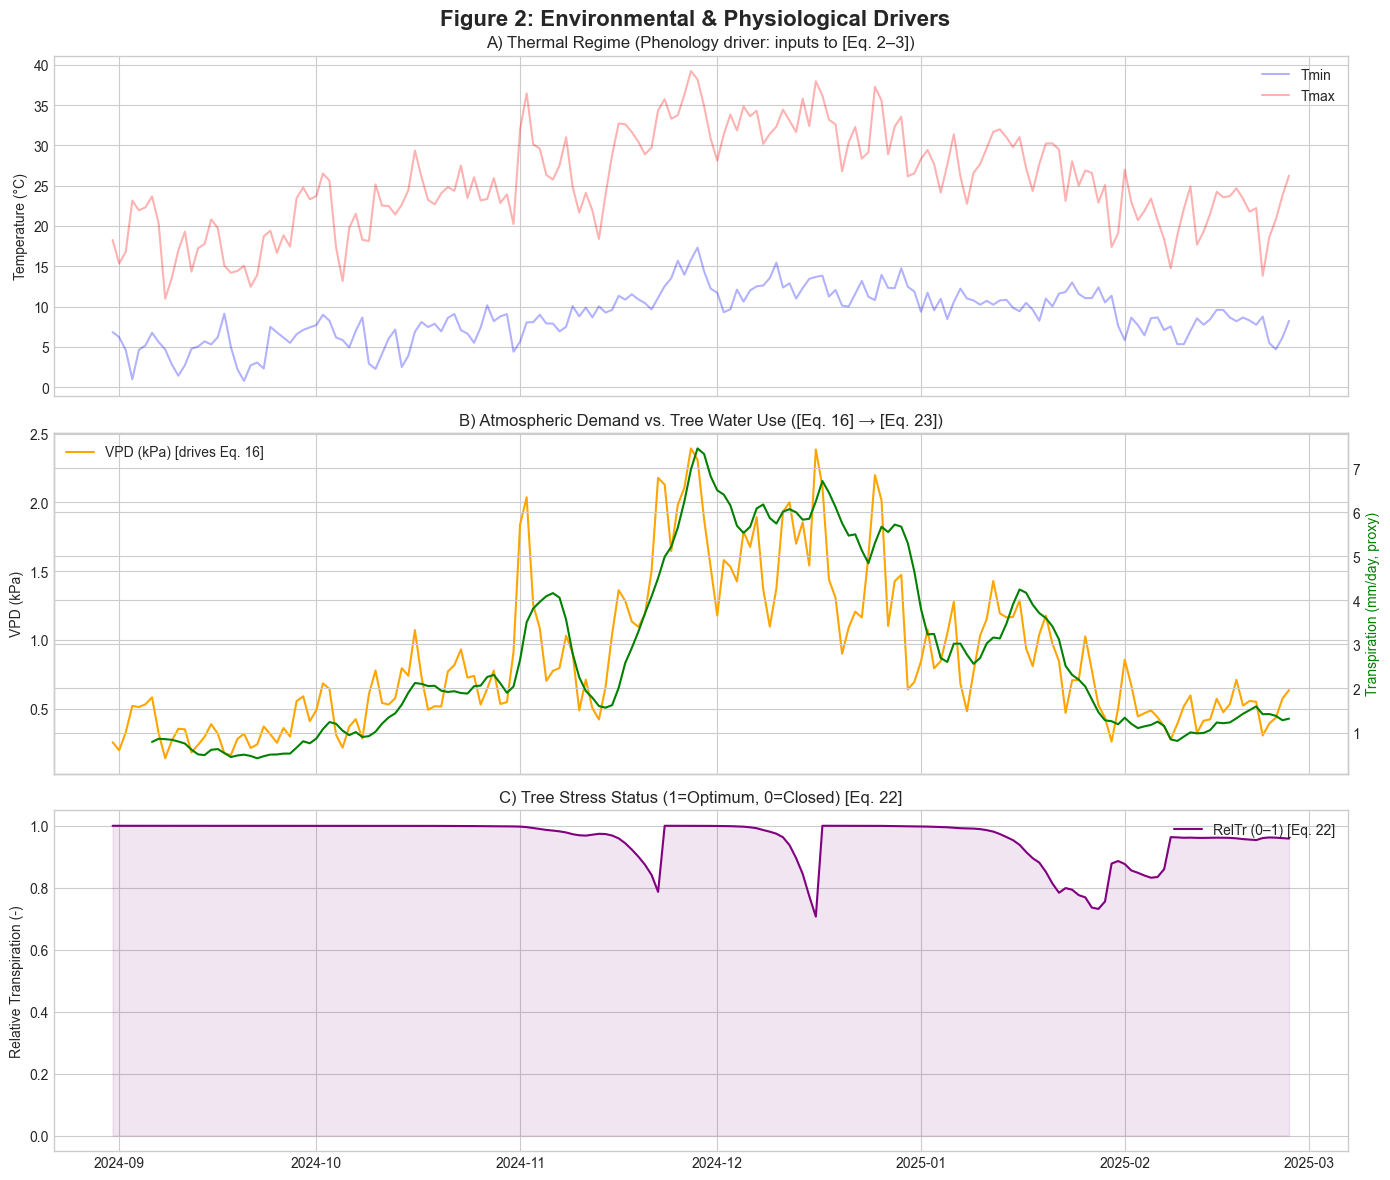

In [4]:
# ==========================================================
# OLIVE ORCHARD MODEL (Chile – Terramater / Olivares de Peteroa)
# Full updated script with:
#   (i) One-season Chile subsetting (Southern Hemisphere)
#   (ii) Radiation unit auto-detection (kWh/m²/day vs MJ/m²/day)
#   (iii) Mandatory equation mapping in function comments
#   (iv) Figure 1–2 plotting as functions (using model outputs)
#   (v) Incorporated local paths for your saved figures + reference table images
# ==========================================================
# --- Minimal QC ---

VERBOSE = True
if "RH2M" in df.columns:
    df["RH2M"] = df["RH2M"].clip(lower=0, upper=100)
for col in ["PRECTOTCORR", "ALLSKY_SFC_SW_DWN"]:
    if col in df.columns:
        df[col] = df[col].clip(lower=0)

if VERBOSE:
    print(f"[INFO] Final modelling dataframe: {df.index.min().date()} -> {df.index.max().date()} | n={len(df)}")

params = dict(
    # --- ARCHITECTURE (super-intensive) ---
    PlantD=1600.0,                 # [trees/ha]
    PlantA=10000.0 / 1600.0,        # [m2/tree]
    LAD=2.0,                        # [m2/m3]

    # --- PHENOLOGY MODEL SELECTION ---
    phenology_chill_model="unichill",    # "unichill" (Eq.2) or "triangular_alt"
    phenology_forcing_model="logistic",  # "logistic" (Eq.3) or "gdd_alt"

    # --- Eq. (1) GDH / heat requirement (paper is hourly; daily approximation if used) ---
    tb_budbreak=8.5,                # [°C]

    # --- Eq. (2) UniChill parameters (CALIBRATE for Chile) ---
    chill_a=0.01,
    chill_b=-0.50,
    chill_c=7.20,
    Ccrit=350.0,                    # threshold

    # --- Eq. (3) Forcing Units parameters (CALIBRATE for Chile) ---
    forcing_d=0.50,
    forcing_e=9.00,
    FcritFlo=450.0,                 # threshold

    # --- ALT phenology (NOT Eq. 2–3) ---
    T_opt_chill_alt=7.2,            # [°C]
    T_max_chill_alt=16.0,           # [°C]
    Tb_forcing_alt=9.0,             # [°C]

    # --- GROWTH (Eq. 4–11) ---
    RUE_ol=0.98,                    # [g DM/MJ] (paper text)
    SLA_ol=5.2,                     # [m2/kg]
    HI_pot_base=0.35,               # [-] paper: unstressed HI = 0.35
    harvest_doy=120,                # [DOY] Chile initial guess (calibrate)
    PClf_pot_base=0.18,             # [-] baseline partition coefficient to leaves (proxy)

    # --- CANOPY LIGHT (Eq. 5–7) ---
    Ck1=0.52, Ck2=0.000788, Ck3=0.76, Ck4=1.25,

    # --- SOIL (Eq. 17–21) ---
    TTSW1=70.0,                     # [mm]
    TTSW2=110.0,                    # [mm]
    Initial_Saturation=0.90,         # [-]
    root_frac_layer1=40.0 / 120.0,
    root_frac_layer2=80.0 / 120.0,

    # --- STRESS RESPONSE (Eq. 22) ---
    RelTr_a=6.17,
    RelTr_b=13.45,
    RelLAI_a=78.24,
    RelLAI_b=21.42,

    # --- Eq. (16) Transpiration efficiency ---
    TE_coeff=4.0,                   # Kd (paper uses Pa, VPD in kPa)

    # --- IRRIGATION MANAGEMENT (used in Eq. 18 recharge) ---
    Irrigation_Threshold=0.20,       # trigger when FTSW < threshold
    Irrigation_Efficiency=0.95,

    # --- EVAPORATION (Eq. 32–34) ---
    SALB=0.20,                       # [-]
    gamma_kpa=0.68,                  # [kPa/°C]

    # --- HI stress at anthesis (Eq. 35–36) ---
    FTSWo=0.40,
    FTSWm=0.05,
    TMAXo=30.0,                      # [°C]
    TMAXm=40.0,                      # [°C]
    anthesis_window_days=7,

    # --- OUTPUT CONVERSION ---
    fresh_factor=2.2,                # DM->fresh proxy
)

# Adult orchard initialization (state)
params["LAI_ini"] = 3.5


# ==========================================================
# 3. FUNCTIONS (MANDATORY Equation Mapping)
# ==========================================================

# --------------------------
# [Eq. 1] GDH (paper is hourly; daily approximation only)
# --------------------------
def eq1_gdh_daily(Tavg, tb):
    """[Eq. 1] GDH daily approximation: GDH = max(0, Tavg - tb)."""
    return max(0.0, Tavg - tb)

# --------------------------
# [Eq. 2] UniChill
# --------------------------
def eq2_unichill(Tavg, a, b, c):
    """
    [Eq. 2] Chill Units (UniChill):
      CU = 1/(1 + exp(a*(T-c)^2 + b*(T-c))).
    """
    z = a * (Tavg - c) ** 2 + b * (Tavg - c)
    return 1.0 / (1.0 + np.exp(z))

# --------------------------
# [Eq. 3] Forcing Units (logistic)
# --------------------------
def eq3_forcing_logistic(Tavg, d, e):
    """
    [Eq. 3] Forcing Units:
      FU = 1/(1 + exp(-d*(T-e))).
    """
    z = -d * (Tavg - e)
    return 1.0 / (1.0 + np.exp(z))

# --------------------------
# [ALT] Chill triangular (NOT Eq. 2)
# --------------------------
def alt_chill_triangular(Tmean, Topt, Tmax):
    """[ALT] Triangular chill (NOT Eq. 2)."""
    if Tmean <= 0 or Tmean >= Tmax:
        return 0.0
    return (Tmean / Topt) if Tmean <= Topt else ((Tmax - Tmean) / (Tmax - Topt))

# --------------------------
# [ALT] Forcing via GDD (NOT Eq. 3)
# --------------------------
def alt_forcing_gdd(Tavg, Tb):
    """[ALT] GDD forcing (NOT Eq. 3): max(0, Tavg - Tb)."""
    return max(0.0, Tavg - Tb)

# --------------------------
# [Eq. 6] k'
# --------------------------
def eq6_k_prime(PlantD, LAD, p):
    """
    [Eq. 6] Extinction coefficient:
      k' = Ck1 + Ck2*PlantD - Ck3*exp(-Ck4*LAD).
    """
    return p["Ck1"] + p["Ck2"] * PlantD - p["Ck3"] * np.exp(-p["Ck4"] * LAD)

# --------------------------
# [Eq. 7/9] v from LAI and LAD
# --------------------------
def eq7_v_from_lai(LAI, LAD):
    """
    [Eq. 7/9] Canopy volume per ground area (consistent state derivation):
      v = LAI / LAD  (units: m3/m2).
    """
    return LAI / max(1e-9, LAD)

# --------------------------
# [Eq. 5] Int_OT
# --------------------------
def eq5_int_ot(k_prime, v):
    """
    [Eq. 5] Intercepted radiation fraction:
      Int_OT = 1 - exp(-k' * v).
    """
    return 1.0 - np.exp(-k_prime * v)

# --------------------------
# [Eq. 4] DM potential
# NOTE: Use PAR (MJ/m²/day) as the radiation driver for biomass (common in crop models).
# --------------------------
def eq4_dm_pot(Int_OT, RAD_MJ_for_DM, RUE):
    """
    [Eq. 4] DM_pot = Int_OT * RAD * RUE
    Returns DM_pot in g/m²/day if RAD is MJ/m²/day and RUE is g/MJ.
    """
    return Int_OT * RAD_MJ_for_DM * RUE

# --------------------------
# [Eq. 16] TE
# --------------------------
def eq16_te(Kd_pa, VPD_kpa):
    """
    [Eq. 16] TE = Kd / VPD
    Paper uses Kd in Pa and VPD in kPa.
    """
    return Kd_pa / max(1e-6, VPD_kpa)

# --------------------------
# [Eq. 15] Transpiration potential
# --------------------------
def eq15_tr_pot(DM_pot_gm2, TE):
    """
    [Eq. 15] Tr_pot = DM_pot / TE
    Used consistently as a water-demand proxy.
    """
    return DM_pot_gm2 / max(1e-9, TE)

# --------------------------
# [Eq. 17] TTSW total
# --------------------------
def eq17_ttsw(TTSW1, TTSW2):
    """[Eq. 17] TTSW = TTSW1 + TTSW2."""
    return TTSW1 + TTSW2

# --------------------------
# [Eq. 18–19] Soil recharge (two layers)
# --------------------------
def eq18_19_recharge(ATSW1, ATSW2, Rain, Ir, TTSW1, TTSW2):
    """
    [Eq. 18] ATSW1_t = min(ATSW1_{t-1} + Rain + Ir, TTSW1)
    [Eq. 19] ATSW2_t = min(ATSW2_{t-1} + excess_from_layer1, TTSW2)
    """
    ATSW1_new = ATSW1 + Rain + Ir
    excess = max(0.0, ATSW1_new - TTSW1)
    ATSW1_new = min(ATSW1_new, TTSW1)
    ATSW2_new = min(ATSW2 + excess, TTSW2)
    return ATSW1_new, ATSW2_new

# --------------------------
# [Eq. 20] FTSW1
# --------------------------
def eq20_ftsw1(ATSW1, TTSW1):
    """[Eq. 20] FTSW1 = ATSW1/TTSW1."""
    return ATSW1 / max(1e-9, TTSW1)

# --------------------------
# [Eq. 21] FTSW (whole profile)
# --------------------------
def eq21_ftsw(ATSW1, ATSW2, TTSW1, TTSW2):
    """[Eq. 21] FTSW = (ATSW1+ATSW2)/(TTSW1+TTSW2)."""
    return (ATSW1 + ATSW2) / max(1e-9, (TTSW1 + TTSW2))

# --------------------------
# [Eq. 22] Relative stress factor
# --------------------------
def eq22_rel_factor(FTSW, a, b):
    """[Eq. 22] Rel = 1/(1 + a*exp(-b*FTSW))."""
    return 1.0 / (1.0 + a * np.exp(-b * FTSW))

# --------------------------
# [Eq. 23] Actual transpiration
# --------------------------
def eq23_atr(Tr_pot, RelTr):
    """[Eq. 23] Tr_act = Tr_pot * RelTr."""
    return Tr_pot * RelTr

# --------------------------
# [Eq. 24] Actual leaf-area increment
# --------------------------
def eq24_alai_inc(LAI_inc_pot, RelLAI):
    """[Eq. 24] ALAI_inc = LAI_inc_pot * RelLAI."""
    return LAI_inc_pot * RelLAI

# --------------------------
# [Eq. 27] RelTE
# --------------------------
def eq27_relte(RelTr):
    """[Eq. 27] RelTE = -0.74*RelTr + 1.74."""
    return -0.74 * RelTr + 1.74

# --------------------------
# [Eq. 28] Actual biomass
# --------------------------
def eq28_dm_act(DM_pot, RelTr, RelTE):
    """[Eq. 28] DM_act = DM_pot * RelTr * RelTE."""
    return DM_pot * RelTr * RelTE

# --------------------------
# [Eq. 8] LAI increment from biomass partition to leaves
# --------------------------
def eq8_lai_inc_pot(DM_pot_gm2, PClf_pot, SLA_m2_per_kg):
    """
    [Eq. 8] LAI_inc_pot = (DM_pot * PClf_pot) * SLA
    DM_pot is g/m²/day -> convert to kg/m²/day before SLA.
    """
    DM_leaf_kgm2 = (DM_pot_gm2 * PClf_pot) / 1000.0
    return DM_leaf_kgm2 * SLA_m2_per_kg

# --------------------------
# [Eq. 10] LAI senescence (distributed over DOY window using YLAI_{y-2})
# --------------------------
def eq10_lai_senescence(doy, YLAI_y_minus_2, DOY_ini=250, DOY_end=330):
    """
    [Eq. 10] LAI_sen = YLAI_{y-2}/(DOY_end-DOY_ini+1) within window, else 0.
    NOTE: DOY_ini/DOY_end should be calibrated to olive phenology; kept as placeholders.
    """
    if YLAI_y_minus_2 <= 0:
        return 0.0
    if DOY_ini <= doy <= DOY_end:
        return YLAI_y_minus_2 / float(DOY_end - DOY_ini + 1)
    return 0.0

# --------------------------
# [Eq. 33] Delta (slope of saturation vapour pressure curve)
# --------------------------
def eq33_delta_kpa_per_c(Tavg):
    """[Eq. 33] Delta from Tetens (kPa/°C)."""
    es = 0.6108 * np.exp(17.27 * Tavg / (Tavg + 237.3))
    return 4098.0 * es / ((Tavg + 237.3) ** 2)

# --------------------------
# [Eq. 32] Potential soil evaporation (energy-limited form)
# --------------------------
def eq32_sevp_pot(SRAD_MJ, SALB, INT_tot, Delta, gamma_kpa=0.68, lambda_mj_per_mm=2.45):
    """
    [Eq. 32] SEVP_pot = SRAD*(1-SALB)*(1-INT_tot) * Delta/(Delta+gamma)
    Convert MJ/m² to mm via lambda (2.45 MJ/mm).
    """
    net_rad = SRAD_MJ * (1.0 - SALB) * (1.0 - INT_tot)
    mm_equiv = net_rad / max(1e-9, lambda_mj_per_mm)
    return mm_equiv * (Delta / max(1e-9, (Delta + gamma_kpa)))

# --------------------------
# [Eq. 34] Actual soil evaporation under drying cycle
# --------------------------
def eq34_sevp(sevp_pot, DYSE):
    """[Eq. 34] SEVP = SEVP_pot*(sqrt(DYSE)-sqrt(DYSE-1))."""
    DYSE = max(1.0, float(DYSE))
    return sevp_pot * (np.sqrt(DYSE) - np.sqrt(max(0.0, DYSE - 1.0)))

# --------------------------
# [Eq. 35] HI water-stress at anthesis
# --------------------------
def eq35_hiws(HI_pot, FTSWant, FTSWo=0.40, FTSWm=0.05):
    """
    [Eq. 35] HIws = HI_pot if FTSWant>FTSWo
                  else HI_pot*(1-(FTSWo-FTSWant)/(FTSWo-FTSWm)).
    """
    if FTSWant >= FTSWo:
        return HI_pot
    if FTSWant <= FTSWm:
        return 0.0
    return HI_pot * (1.0 - (FTSWo - FTSWant) / max(1e-9, (FTSWo - FTSWm)))

# --------------------------
# [Eq. 36] HI heat-stress at anthesis
# --------------------------
def eq36_hihs(HI_pot, TMAXant, TMAXo=30.0, TMAXm=40.0):
    """
    [Eq. 36] HIhs = HI_pot if TMAXant<TMAXo
                  else HI_pot*(1-(TMAXant-TMAXo)/(TMAXm-TMAXo)).
    """
    if TMAXant <= TMAXo:
        return HI_pot
    if TMAXant >= TMAXm:
        return 0.0
    return HI_pot * (1.0 - (TMAXant - TMAXo) / max(1e-9, (TMAXm - TMAXo)))

# --------------------------
# [Eq. 11] Yield
# --------------------------
def eq11_yield(HI_actual, DM_cum_gm2):
    """[Eq. 11] Yield_gm2 = HI * DM_cum (up to harvest)."""
    return HI_actual * DM_cum_gm2

# --------------------------
# [Eq. 37–40] Alternate bearing updates (apply at season boundary)
# --------------------------
def eq37_40_update_next_season(HIa, HI_pot_base=0.35, PClf_pot_base=0.18):
    """
    [Eq. 37–40] Unified forms (paper-derived):
      HI_pot_next = 0.70 - HIa      (clamped)
      PClf_next   = PClf_base*(0.65 + HIa)
    """
    HI_pot_next = max(0.0, min(0.70, 0.70 - HIa))
    PClf_next = max(0.0, PClf_pot_base * (0.65 + HIa))
    return HI_pot_next, PClf_next

# --------------------------
# [Eq. 41] Alternate Bearing Index (ABI)
# --------------------------
def eq41_abi(yields):
    """[Eq. 41] ABI = (1/(n-1)) * sum(|Yi - Yi+1|/(Yi + Yi+1))."""
    ys = [y for y in yields if y is not None and not np.isnan(y)]
    n = len(ys)
    if n < 2:
        return np.nan
    terms = []
    for i in range(n - 1):
        denom = ys[i] + ys[i + 1]
        terms.append(abs(ys[i] - ys[i + 1]) / denom if denom > 0 else 0.0)
    return sum(terms) / (n - 1)


# ==========================================================
# 4. PRE-PROCESSING (Mapped variables)
# NASA POWER daily columns assumed:
#   T2M_MAX, T2M_MIN, ALLSKY_SFC_SW_DWN, RH2M, PRECTOTCORR
# ==========================================================
df = df.copy()
df["TAVG"] = (df["T2M_MAX"] + df["T2M_MIN"]) / 2.0

# --- Radiation unit detection for ALLSKY_SFC_SW_DWN ---
# Heuristic:
#   - kWh/m²/day typically ~ 2–9
#   - MJ/m²/day typically ~ 10–30
allsky_mean = float(df["ALLSKY_SFC_SW_DWN"].mean())
if allsky_mean < 12.0:
    rad_factor = 3.6
    if VERBOSE:
        print("[INFO] Radiation units: kWh/m²/day detected (×3.6 -> MJ/m²/day)")
else:
    rad_factor = 1.0
    if VERBOSE:
        print("[INFO] Radiation units: MJ/m²/day detected (×1.0)")

df["SRAD_MJ"] = df["ALLSKY_SFC_SW_DWN"] * rad_factor          # for [Eq. 32] (energy)
df["PAR_MJ"]  = df["SRAD_MJ"] * 0.48                          # for [Eq. 4] (biomass driver)

if VERBOSE:
    print(f"[INFO] Mean ALLSKY={allsky_mean:.2f} | Mean SRAD_MJ={df['SRAD_MJ'].mean():.2f} | Mean RAD_MJ(PAR)={df['PAR_MJ'].mean():.2f}")

# --- VPD (kPa) for [Eq. 16] (Tetens; uses TAVG and RH2M) ---
es = 0.6108 * np.exp(17.27 * df["TAVG"] / (df["TAVG"] + 237.3))
ea = es * (df["RH2M"] / 100.0)
df["VPD_kPa"] = np.maximum(0.1, es - ea)

# --- Rain (mm) for [Eq. 18] ---
df["RAIN_mm"] = df["PRECTOTCORR"]


# ==========================================================
# 5. SIMULATION LOOP (Chile-consistent season handling)
# Season year definition: Southern Hemisphere Jul–Jun
#   season_year = year if month >= 7 else year - 1
# ==========================================================
LAI = params["LAI_ini"]
ATSW1 = params["TTSW1"] * params["Initial_Saturation"]
ATSW2 = params["TTSW2"] * params["Initial_Saturation"]
DYSE = 1

# Phenology accumulators (per season)
chill_cum = 0.0
forcing_cum = 0.0
dormancy_released = False
anthesis_occurred = False
anthesis_date = None

# HI state (per season)
HI_pot = params["HI_pot_base"]
HIa = HI_pot
HIa_fixed = False
anthesis_FTSW_samples = []
anthesis_TMAX_samples = []

# Biomass accumulation for [Eq. 11] (per season; stops at harvest)
DM_cum = 0.0

# Alternate bearing / memory across seasons
year_state = dict(
    YLAI_prod_by_season={},
    HIa_by_season={},
    yield_by_season={},
)
YLAI_produced_this_season = 0.0

results = []

print(f"--- STARTING SIMULATION: ---")
print(f"Date window: {df.index.min().date()} to {df.index.max().date()}")
print(f"Strategy: Irrigation Threshold = {params['Irrigation_Threshold']:.2f} (FTSW)")
print(f"Harvest DOY (Chile init): {params['harvest_doy']}  (calibrate with farm records)")
print(f"Phenology models: Chill={params['phenology_chill_model']} | Forcing={params['phenology_forcing_model']}")

for date, row in df.iterrows():
    year = int(date.year)
    doy = int(date.dayofyear)
    season_year = year if date.month >= 7 else year - 1

    # ------------------------------------------------------
    # SEASON RESET at July 1 (Southern Hemisphere)
    # ------------------------------------------------------
    if (date.month == 7) and (date.day == 1):
        prev_season = season_year - 1

        if prev_season not in year_state["YLAI_prod_by_season"]:
            year_state["YLAI_prod_by_season"][prev_season] = YLAI_produced_this_season
        YLAI_produced_this_season = 0.0

        prev_HIa = year_state["HIa_by_season"].get(prev_season, params["HI_pot_base"])
        HI_pot, PClf_next = eq37_40_update_next_season(
            prev_HIa, HI_pot_base=params["HI_pot_base"], PClf_pot_base=params["PClf_pot_base"]
        )
        params["PClf_pot_base"] = PClf_next

        chill_cum = 0.0
        forcing_cum = 0.0
        dormancy_released = False
        anthesis_occurred = False
        anthesis_date = None
        HIa = HI_pot
        HIa_fixed = False
        anthesis_FTSW_samples = []
        anthesis_TMAX_samples = []
        DM_cum = 0.0
        DYSE = 1

        if VERBOSE:
            print(f"\n--- SEASON {season_year}-{season_year+1} RESET (Jul 1) ---")
            print(f"    HI_pot updated [Eq.37–40] -> {HI_pot:.3f} | PClf_pot -> {params['PClf_pot_base']:.3f}")

    # ------------------------------------------------------
    # PHENOLOGY: Eq. (2) and Eq. (3) with daily TAVG
    # IMPORTANT: Eq.(2)-(3) are hourly in the paper; using daily TAVG
    # we scale by 24 to approximate hourly integration magnitudes.
    # ------------------------------------------------------
    Tavg = float(row["TAVG"])

    if not dormancy_released:
        if params["phenology_chill_model"] == "unichill":
            CU = eq2_unichill(Tavg, params["chill_a"], params["chill_b"], params["chill_c"])  # [Eq. 2]
            chill_cum += CU * 24.0
        else:
            CU_alt = alt_chill_triangular(Tavg, params["T_opt_chill_alt"], params["T_max_chill_alt"])
            chill_cum += CU_alt * 24.0

        if chill_cum >= params["Ccrit"]:
            dormancy_released = True
            if VERBOSE:
                print(f"[PHENO] {date.date()} dormancy released | chill_cum={chill_cum:.1f}")

    elif not anthesis_occurred:
        if params["phenology_forcing_model"] == "logistic":
            FU = eq3_forcing_logistic(Tavg, params["forcing_d"], params["forcing_e"])          # [Eq. 3]
            forcing_cum += FU * 24.0
        else:
            forcing_cum += alt_forcing_gdd(Tavg, params["Tb_forcing_alt"])

        if forcing_cum >= params["FcritFlo"]:
            anthesis_occurred = True
            anthesis_date = date
            if VERBOSE:
                print(f"[PHENO] {date.date()} anthesis reached")

    # ------------------------------------------------------
    # CANOPY / LIGHT: Eq. (6) -> Eq. (7/9) -> Eq. (5)
    # ------------------------------------------------------
    k_prime = eq6_k_prime(params["PlantD"], params["LAD"], params)   # [Eq. 6]
    v = eq7_v_from_lai(LAI, params["LAD"])                           # [Eq. 7/9]
    Int_OT = eq5_int_ot(k_prime, v)                                  # [Eq. 5]

    # ------------------------------------------------------
    # POTENTIAL GROWTH: Eq. (4) using PAR_MJ as radiation input
    # ------------------------------------------------------
    PAR_MJ = float(row["PAR_MJ"])
    DM_pot = eq4_dm_pot(Int_OT, PAR_MJ, params["RUE_ol"])            # [Eq. 4]

    # ------------------------------------------------------
    # IRRIGATION + SOIL RECHARGE: Eq. (18–19), status Eq. (20–21)
    # ------------------------------------------------------
    total_capacity = eq17_ttsw(params["TTSW1"], params["TTSW2"])      # [Eq. 17]
    current_FTSW = eq21_ftsw(ATSW1, ATSW2, params["TTSW1"], params["TTSW2"])  # [Eq. 21]

    irrigation_today = 0.0
    if (current_FTSW < params["Irrigation_Threshold"]) and (date.month in [9, 10, 11, 12, 1, 2, 3, 4]):
        deficit = total_capacity - (ATSW1 + ATSW2)
        irrigation_today = deficit / max(1e-9, params["Irrigation_Efficiency"])

    Rain = float(row["RAIN_mm"])
    Ir = float(irrigation_today)

    ATSW1, ATSW2 = eq18_19_recharge(ATSW1, ATSW2, Rain, Ir, params["TTSW1"], params["TTSW2"])  # [Eq. 18–19]

    FTSW1 = eq20_ftsw1(ATSW1, params["TTSW1"])                       # [Eq. 20]
    FTSW = eq21_ftsw(ATSW1, ATSW2, params["TTSW1"], params["TTSW2"]) # [Eq. 21]

    # ------------------------------------------------------
    # STRESS: Eq. (22), Eq. (27), Eq. (28)
    # ------------------------------------------------------
    RelTr = eq22_rel_factor(FTSW, params["RelTr_a"], params["RelTr_b"])        # [Eq. 22]
    RelLAI = eq22_rel_factor(FTSW, params["RelLAI_a"], params["RelLAI_b"])     # [Eq. 22]
    RelTE = eq27_relte(RelTr)                                                  # [Eq. 27]
    DM_act = eq28_dm_act(DM_pot, RelTr, RelTE)                                 # [Eq. 28]

    # ------------------------------------------------------
    # TRANSPIRATION: Eq. (16) -> Eq. (15) -> Eq. (23)
    # ------------------------------------------------------
    VPD_kPa = float(row["VPD_kPa"])
    TE = eq16_te(params["TE_coeff"], VPD_kPa)                                  # [Eq. 16]
    Tr_pot = eq15_tr_pot(DM_pot, TE)                                           # [Eq. 15]
    Tr_act = eq23_atr(Tr_pot, RelTr)                                           # [Eq. 23]

    # ------------------------------------------------------
    # SOIL EVAPORATION: Eq. (32–34) uses SRAD_MJ (total energy, not PAR)
    # ------------------------------------------------------
    if (Rain + Ir) > 0.5:
        DYSE = 1
    else:
        DYSE += 1

    SRAD_MJ = float(row["SRAD_MJ"])
    Delta = eq33_delta_kpa_per_c(Tavg)                                         # [Eq. 33]
    SEVP_pot = eq32_sevp_pot(SRAD_MJ, params["SALB"], Int_OT, Delta, params["gamma_kpa"])  # [Eq. 32]
    SEVP = eq34_sevp(SEVP_pot, DYSE)                                           # [Eq. 34]

    # ------------------------------------------------------
    # WATER UPTAKE: Eq. (30–31) operationalized via root fractions
    # ------------------------------------------------------
    Tr1 = Tr_act * params["root_frac_layer1"]
    Tr2 = Tr_act * params["root_frac_layer2"]

    ATSW1 -= (Tr1 + SEVP)
    if ATSW1 < 0:
        deficit = -ATSW1
        ATSW1 = 0.0
        ATSW2 = max(0.0, ATSW2 - deficit)

    ATSW2 = max(0.0, ATSW2 - Tr2)

    FTSW1 = eq20_ftsw1(ATSW1, params["TTSW1"])                                  # [Eq. 20]
    FTSW = eq21_ftsw(ATSW1, ATSW2, params["TTSW1"], params["TTSW2"])            # [Eq. 21]

    # ------------------------------------------------------
    # HI AT ANTHESIS: Eq. (35–36), additive HIa rule
    # ------------------------------------------------------
    if anthesis_occurred and (not HIa_fixed):
        anthesis_FTSW_samples.append(FTSW)
        anthesis_TMAX_samples.append(float(row["T2M_MAX"]))

        if len(anthesis_FTSW_samples) >= params["anthesis_window_days"]:
            FTSWant = float(np.mean(anthesis_FTSW_samples))
            TMAXant = float(np.mean(anthesis_TMAX_samples))

            HIws = eq35_hiws(HI_pot, FTSWant, params["FTSWo"], params["FTSWm"])  # [Eq. 35]
            HIhs = eq36_hihs(HI_pot, TMAXant, params["TMAXo"], params["TMAXm"])  # [Eq. 36]

            HIa = max(0.0, min(HI_pot, HIws + HIhs - HI_pot))
            HIa_fixed = True

            year_state["HIa_by_season"][season_year] = HIa

            if VERBOSE:
                print(f"[HI] {date.date()} HIa fixed | HIws={HIws:.3f}, HIhs={HIhs:.3f}, HIa={HIa:.3f}")

    # ------------------------------------------------------
    # LEAF GROWTH: Eq. (8) + Eq. (24); Senescence Eq. (10); LAI update
    # ------------------------------------------------------
    PClf_pot = params["PClf_pot_base"]

    LAI_inc_pot = eq8_lai_inc_pot(DM_pot, PClf_pot, params["SLA_ol"])          # [Eq. 8]
    ALAI_inc = eq24_alai_inc(LAI_inc_pot, RelLAI)                               # [Eq. 24]

    if ALAI_inc > 0:
        YLAI_produced_this_season += ALAI_inc

    YLAI_y_minus_2 = year_state["YLAI_prod_by_season"].get(season_year - 2, 0.0)
    LAI_sen = eq10_lai_senescence(doy, YLAI_y_minus_2)                          # [Eq. 10]

    LAI = max(0.1, LAI + ALAI_inc - LAI_sen)

    # ------------------------------------------------------
    # YIELD ACCUMULATION: Eq. (11), STOP at harvest DOY
    # ------------------------------------------------------
    harvest_passed = (date.month <= 6) and (doy >= int(params["harvest_doy"]))

    if dormancy_released and (not harvest_passed):
        DM_cum += DM_act

    yield_gm2 = eq11_yield(HIa if HIa_fixed else HI_pot, DM_cum)                # [Eq. 11]

    results.append(
        dict(
            DATE=date,
            SEASON_YEAR=season_year,
            DOY=doy,
            LAI=LAI,
            v=v,
            k_prime=k_prime,
            Int_OT=Int_OT,
            DM_pot=DM_pot,
            DM_act=DM_act,
            DM_cum=DM_cum,
            HI_pot=HI_pot,
            HIa=HIa if HIa_fixed else np.nan,
            Yield_gm2=yield_gm2,
            ATSW1=ATSW1,
            ATSW2=ATSW2,
            FTSW1=FTSW1,
            FTSW=FTSW,
            RelTr=RelTr,
            RelLAI=RelLAI,
            RelTE=RelTE,
            TE=TE,
            Tr_pot=Tr_pot,
            Tr_act=Tr_act,
            SEVP_pot=SEVP_pot,
            SEVP=SEVP,
            DYSE=DYSE,
            Rain=Rain,
            Irrigation=Ir,
            VPD_kPa=VPD_kPa,
            dormancy_released=dormancy_released,
            anthesis_occurred=anthesis_occurred,
            harvest_passed=harvest_passed,
        )
    )


# ==========================================================
# 6. RESULTS & AUDIT (Chile-consistent: group by SEASON_YEAR)
# Includes ABI [Eq. 41]
# ==========================================================
res_df = pd.DataFrame(results).set_index("DATE")

seasonal_yield_gm2 = res_df.groupby("SEASON_YEAR")["Yield_gm2"].max()
seasonal_yield_kg_ha_dm = seasonal_yield_gm2 * 10.0
seasonal_yield_kg_ha_fresh = seasonal_yield_kg_ha_dm * params["fresh_factor"]

seasonal_irrig_mm = res_df.groupby("SEASON_YEAR")["Irrigation"].sum()

abi = eq41_abi([seasonal_yield_kg_ha_dm.loc[s] for s in seasonal_yield_kg_ha_dm.index])

# With one season, ABI will be NaN by definition; keep behavior explicit.
if len(seasonal_yield_kg_ha_dm) >= 3:
    core_seasons = seasonal_yield_kg_ha_dm.index[1:-1]
    avg_yield_dm = seasonal_yield_kg_ha_dm.loc[core_seasons].mean()
    avg_yield_fresh = seasonal_yield_kg_ha_fresh.loc[core_seasons].mean()
    avg_irrig = seasonal_irrig_mm.loc[core_seasons].mean()
else:
    avg_yield_dm = seasonal_yield_kg_ha_dm.mean()
    avg_yield_fresh = seasonal_yield_kg_ha_fresh.mean()
    avg_irrig = seasonal_irrig_mm.mean()

print("\n" + "=" * 80)
print(f"FINAL AUDIT (Chile) | LOC")
print("=" * 80)
print(f"Seasons evaluated (SEASON_YEAR): {list(seasonal_yield_kg_ha_dm.index)}")
print(f"Phenology models: Chill={params['phenology_chill_model']} | Forcing={params['phenology_forcing_model']}")
print(f"Harvest DOY: {params['harvest_doy']}  | Irrigation threshold FTSW={params['Irrigation_Threshold']:.2f}")
print("-" * 80)
print(f"Average Yield (DM):      {avg_yield_dm:.0f} kg/ha")
print(f"Average Yield (Fresh*):  {avg_yield_fresh:.0f} kg/ha   (*fresh_factor={params['fresh_factor']})")
print(f"Average Irrigation:      {avg_irrig:.0f} mm/season-year")
print(f"Alternate Bearing Index: {abi:.3f}   [Eq. 41]")
print("-" * 80)

if avg_yield_fresh > 12000:
    print("STATUS: Commercial super-intensive yield range (fresh basis).")
elif avg_yield_fresh > 5000:
    print("STATUS: Moderate yield range (fresh basis).")
else:
    print("STATUS: Low yield; calibrate Eq. (2–3) using observed anthesis dates and confirm harvest DOY for Peteroa.")


# ==========================================================
# 7. VISUALIZATION (FIGURES) - as functions using model outputs
# ==========================================================
def plot_figures_chile(df_weather, res_df, params, LOC, avg_irrig_mm, save_figs=True):
    """
    Generates:
      Figure 1: Production & Water Balance
      Figure 2: Environmental & Physiological Drivers

    Expected columns:
      df_weather: T2M_MAX, T2M_MIN
      res_df: DM_pot, DM_act, FTSW, Irrigation, Yield_gm2, LAI, VPD_kPa, Tr_act, RelTr
    """

    plt.style.use("seaborn-v0_8-whitegrid")

    # -------------------------
    # FIGURE 1
    # -------------------------
    fig1, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig1.suptitle(f"Figure 1: Production & Water Balance - {LOC}", fontsize=16, fontweight="bold")

    # A) Biomass Gap
    ax1 = axes[0, 0]
    ax1.plot(res_df.index, res_df["DM_pot"].rolling(14).mean(), color="lightgray", ls="--", label="Potential [Eq. 4]")
    ax1.fill_between(res_df.index, res_df["DM_act"].rolling(14).mean(), color="forestgreen", alpha=0.6, label="Actual [Eq. 28]")
    ax1.set_title("A) Photosynthesis Gap (Stress Effect)", fontsize=12)
    ax1.set_ylabel("g DM m$^{-2}$ day$^{-1}$")
    ax1.legend()

    # B) Irrigation & Soil Water
    ax2 = axes[0, 1]
    ax2.plot(res_df.index, res_df["FTSW"], color="blue", alpha=0.6, label="Soil Water (FTSW) [Eq. 21]")
    ax2.axhline(params["Irrigation_Threshold"], color="red", ls="--", label="Trigger (FTSW threshold)")
    ax2_bis = ax2.twinx()
    ax2_bis.bar(res_df.index, res_df["Irrigation"], color="cyan", alpha=0.5, width=2, label="Irrigation (mm)")
    ax2_bis.set_ylabel("Irrigation (mm)", color="cyan")
    ax2.set_title(f"B) Water Management (Avg irrigation: {avg_irrig_mm:.0f} mm/season)", fontsize=12)
    ax2.set_ylabel("FTSW (-)")
    ax2.legend(loc="upper left")

    # C) Yield Accumulation
    ax3 = axes[1, 0]
    ax3.plot(res_df.index, res_df["Yield_gm2"], color="olive", lw=2)
    ax3.set_title("C) Yield Accumulation [Eq. 11]", fontsize=12)
    ax3.set_ylabel("g DM m$^{-2}$")

    # D) Canopy Structure
    ax4 = axes[1, 1]
    ax4.plot(res_df.index, res_df["LAI"], color="black", lw=2)
    ax4.set_title("D) Canopy Development (LAI; driven by [Eq. 8, 24, 10])", fontsize=12)
    ax4.set_ylabel("LAI (-)")

    plt.tight_layout()
    plt.show()

    # -------------------------
    # FIGURE 2
    # -------------------------
    fig2, axes2 = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
    fig2.suptitle("Figure 2: Environmental & Physiological Drivers", fontsize=16, fontweight="bold")

    # A) Temperature & Phenology driver inputs
    ax_temp = axes2[0]
    ax_temp.plot(df_weather.index, df_weather["T2M_MIN"], color="blue", alpha=0.3, label="Tmin")
    ax_temp.plot(df_weather.index, df_weather["T2M_MAX"], color="red", alpha=0.3, label="Tmax")
    ax_temp.set_ylabel("Temperature (°C)")
    ax_temp.legend(loc="upper right")
    ax_temp.set_title("A) Thermal Regime (Phenology driver: inputs to [Eq. 2–3])", fontsize=12)

    # B) Atmospheric demand (VPD) vs transpiration
    ax_vpd = axes2[1]
    ax_vpd.plot(res_df.index, res_df["VPD_kPa"], color="orange", label="VPD (kPa) [drives Eq. 16]")
    ax_vpd_bis = ax_vpd.twinx()
    ax_vpd_bis.plot(res_df.index, res_df["Tr_act"].rolling(7).mean(), color="green", lw=1.5, label="Transpiration (proxy) [Eq. 23]")
    ax_vpd_bis.set_ylabel("Transpiration (mm/day, proxy)", color="green")
    ax_vpd.set_ylabel("VPD (kPa)")
    ax_vpd.legend(loc="upper left")
    ax_vpd.set_title("B) Atmospheric Demand vs. Tree Water Use ([Eq. 16] → [Eq. 23])", fontsize=12)

    # C) Physiological status (stress)
    ax_phys = axes2[2]
    ax_phys.plot(res_df.index, res_df["RelTr"], color="purple", lw=1.5, label="RelTr (0–1) [Eq. 22]")
    ax_phys.fill_between(res_df.index, res_df["RelTr"], 0, color="purple", alpha=0.1)
    ax_phys.set_ylabel("Relative Transpiration (-)")
    ax_phys.set_title("C) Tree Stress Status (1=Optimum, 0=Closed) [Eq. 22]", fontsize=12)
    ax_phys.legend(loc="upper right")

    plt.tight_layout()
    plt.show()


def _show_image_if_available(path, title=None):
    """Utility: display an image from a local path, if available."""
    if not SHOW_REFERENCE_IMAGES:
        return
    if not os.path.exists(path):
        print(f"[INFO] Reference image not found: {path}")
        return
    if not _PIL_AVAILABLE:
        print(f"[INFO] PIL not available; cannot display image: {path}")
        return

    img = Image.open(path)
    plt.figure(figsize=(12, 6))
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()


# --- Run plots ---
plot_figures_chile(df, res_df, params, '1', avg_irrig, save_figs=True)

